In [2]:

from functools import partial
from itertools import product
from scipy.spatial.distance import cdist
from scipy.sparse import csc_matrix
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from friendly_guacamole.transforms import (
    FilterSamples,
    UniFrac,
    RarefactionBIOM,
    PCoA,
    AsDense,
    CLR,
)
from friendly_guacamole.datasets import KeyboardDataset
from skbio import DistanceMatrix
from umap import UMAP
from biom import Table
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [3]:
keyboard_data = KeyboardDataset('data/keyboard')
tree = keyboard_data.apply('tree', 'path')

RAREFACTION_DEPTH = 500

Files already downloaded and verified


In [4]:
min_count_filter = FilterSamples(min_count=RAREFACTION_DEPTH)
kb_mf = keyboard_data['metadata']
kb_table = keyboard_data['table']
kb_mf = kb_mf.set_index('sample_name')
metadata = kb_mf[kb_mf.host_subject_id.isin(['M2','M3', 'M9'])]
kb_table = kb_table.filter(metadata.index)
table = min_count_filter.fit_transform(kb_table)
metadata = metadata.loc[table.ids('sample')]

In [5]:
rarefied_table = RarefactionBIOM(RAREFACTION_DEPTH).fit_transform(table)

In [6]:
rarefied_table

1414 x 99 <class 'biom.table.Table'> with 7728 nonzero entries (5% dense)

In [7]:
def postprocess_umap(results):
    return pd.DataFrame(results, columns=[f'PC{i + 1}'
                                          for i in range(results.shape[1])])

In [8]:
aitchison_pipeline = Pipeline([
    ('asdense', AsDense()),
    ('clr', CLR()),
])

In [9]:
aitchison_prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': aitchison_pipeline,
    },
]

prep_tables = [
    {
        'name': 'Aitchison',
        'metric': 'euclidean',
        'pipeline': aitchison_pipeline,
    },
]

In [10]:
def pcoa_amend_axes(transformer, axes_names):
    pe = transformer.ordination_.proportion_explained
    return [f'{axn} ({pexp:.1%})' for pexp, axn in zip(pe, axes_names)]

In [15]:
embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
        'axes': ['PCoA-1', 'PCoA-2'],
        'amend_axes': pcoa_amend_axes,
    },
    {
        'method': 'UMAP\nNeighbors=15',
        'pipeline': partial(UMAP,
                            min_dist=1,
                            random_state=724
                            ),
        'postprocess': postprocess_umap,
        'axes': ['UMAP-1', 'UMAP-2']
    },
    {
        'method': 'UMAP\nNeighbors=80',
        'pipeline': partial(UMAP,
                            min_dist=1,
                            n_neighbors=80,
                            random_state=825),
        'postprocess': postprocess_umap,
        'axes': ['UMAP-1', 'UMAP-2']
    },
    {
        'method': 'UMAP\nNeighbors=98',
        'pipeline': partial(UMAP,
                            min_dist=1,
                            n_neighbors=98,
                            random_state=901),
        'postprocess': postprocess_umap,
        'axes': ['UMAP-1', 'UMAP-2']
    },
]

In [16]:
results = dict()

for prep, emb in product(prep_tables, embedding_methods):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    amend_axes = emb.get('amend_axes', lambda t, labels: labels)
    results[(name, method)] = {'ordination': result,
                               'axes': amend_axes(transformer, emb['axes']),
                               }


In [17]:
v_position_map = {x['name']: i for i, x in enumerate(prep_tables)}
h_position_map = {x['method']: i for i, x in enumerate(embedding_methods)}

metadata['host_surface'] = metadata['host_subject_id'] + \
                           metadata['sample_type']


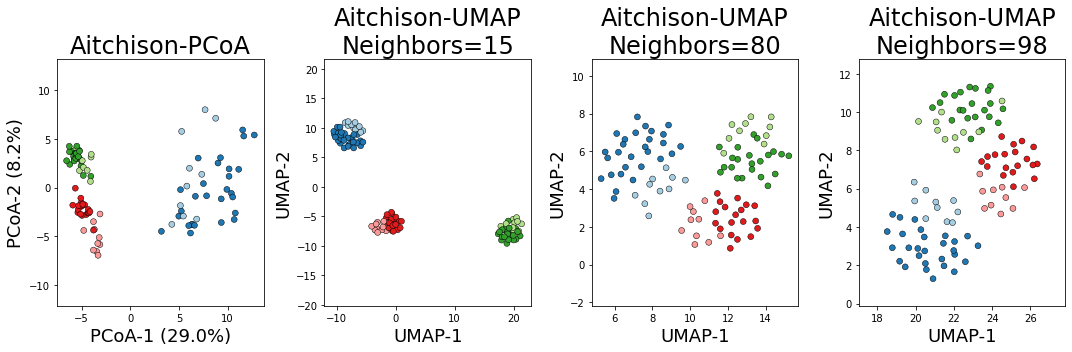

In [18]:
fig, axs = plt.subplots(len(v_position_map), len(h_position_map),
                        figsize=(15, 5),
                        )
for (name, method), result in results.items():
        i = v_position_map[name]
        j = h_position_map[method]
        res = results[(name, method)]['ordination']
        res.index = metadata.index
        res = res.join(metadata)

        g = sns.scatterplot(
            x='PC1',
            y='PC2',
            hue='host_surface',
            hue_order=list(sorted(metadata['host_surface'].unique())),
            # style='sample_type',
            data=res,
            ax=axs[j],
            s=35,
            edgecolor='k',
            palette='Paired',
        )
        g.set_aspect('equal', 'datalim')
        g.legend().remove()

        g.set_title(f'{name}-{method}',
                    color='black',
                    fontsize=24)

        g.set_xlabel(result['axes'][0], color='black', fontsize=18)
        g.set_ylabel(result['axes'][1], color='black', fontsize=18)

plt.tight_layout()
plt.savefig('results/2.0-real-data-keyboard-ordination-aitchison.svg', dpi=300)
plt.show()

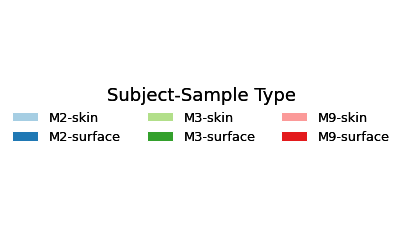

In [19]:
def add_legend(ax, pal, hue_order, patch_kwargs=None, legend_kwargs=None):
    if not legend_kwargs:
        legend_kwargs = dict()
    if not patch_kwargs:
        patch_kwargs = dict()

    palette = sns.color_palette(pal)
    legend_elements = []

    for i, name in enumerate(hue_order):
        new_element = Patch(
            facecolor=palette[i % len(palette)],
            label=name,
            **patch_kwargs,
        )
        legend_elements.append(new_element)

    legend = ax.legend(handles=legend_elements, **legend_kwargs)
    ax.add_artist(legend)
    return legend

fig, ax = plt.subplots()
unique = list(sorted(metadata['host_surface'].unique()))
unique = [u[:2] + '-' + u[2:] for u in unique]

add_legend(ax, 'Paired', unique,
           patch_kwargs=dict(
               edgecolor='w',
               linewidth=1,
           ),
           legend_kwargs=dict(
               loc='center',
               fontsize=13, ncol=3, framealpha=0.0,
               title='Subject-Sample Type',
               title_fontsize=18,
           )
)
ax.axis('off')
plt.savefig('results/2.0-real-data-keyboard-ordination-legend.svg')
plt.show()

In [20]:
clr_coordinates = aitchison_pipeline.fit_transform(table)
distances = cdist(clr_coordinates, clr_coordinates)
adm = DistanceMatrix(
    distances ,
    ids=metadata.index,
)

In [21]:
m2_ids = metadata[metadata.host_subject_id == 'M2'].index
m3_ids = metadata[metadata.host_subject_id == 'M3'].index
m9_ids = metadata[metadata.host_subject_id == 'M9'].index
m2m3 = adm.between(m2_ids, m3_ids)
m2m9 = adm.between(m2_ids, m9_ids)
m3m9 = adm.between(m3_ids, m9_ids)

In [22]:
def ci(dist):
    return dist.mean(), 1.96 * dist.std() / np.sqrt(len(dist))

In [23]:
ci(m2m3)

(value    19.887087
 dtype: float64,
 value    0.106436
 dtype: float64)

In [24]:
ci(m2m9)

(value    18.942012
 dtype: float64,
 value    0.120493
 dtype: float64)

In [25]:
ci(m3m9)

(value    13.867013
 dtype: float64,
 value    0.111524
 dtype: float64)

In [26]:
def get_numeric_index_matching(metadata, category, value):
    new_index = metadata[category].reset_index(drop=True)
    matches = new_index == value
    return new_index.index[matches]

In [27]:
repeat_embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
    },
]

for i in range(10):
    new_methods = [
        {
            'method': 'UMAP\nNeighbors=15',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                random_state=724 + i,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=80',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_neighbors=80,
                                random_state=825 + i
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=98',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_neighbors=98,
                                random_state=901 + i
                                ),
            'postprocess': postprocess_umap,
        },

    ]
    repeat_embedding_methods.extend(new_methods)

In [28]:
repeat_results = dict()

for i, (prep, emb) in enumerate(product(aitchison_prep_tables,
                                repeat_embedding_methods)):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    repeat_results[(i, name, method)] = {'ordination': result}

In [29]:
for (i, name, method), result in repeat_results.items():
    first_pcs = result['ordination'].loc[:, ['PC1', 'PC2']]
    grouping = metadata['host_subject_id']
    score = silhouette_score(first_pcs, grouping)

    result_key = 'within_subject_clustering_silhouette'
    result[result_key] = {'overall': score}
    for subject in metadata['host_subject_id'].unique():
        idx = get_numeric_index_matching(metadata, 'host_subject_id', subject)
        sub_metadata = metadata.iloc[idx]
        sub_pcs = first_pcs.iloc[idx]
        sub_target = sub_metadata['sample_type']
        score = silhouette_score(sub_pcs, sub_target)
        result[result_key][subject] = score

for (i, name, method), result in repeat_results.items():
    result['cluster statistics'] = dict()
    result['cluster statistics']['host'] = \
        result['within_subject_clustering_silhouette']['overall']
    for subject in metadata['host_subject_id'].unique():
        stat = result['within_subject_clustering_silhouette'][subject]
        result['cluster statistics'][f'{subject}-type'] = stat

cluster_statistics = dict()
for (i, name, method), result in repeat_results.items():
    cluster_statistics[(i, name, method)] = result['cluster statistics']

In [30]:
model = LinearDiscriminantAnalysis()

for (i, name, method), result in repeat_results.items():
    first_pcs = result['ordination'].loc[:, ['PC1', 'PC2']]
    grouping = metadata['host_subject_id']
    model.fit(first_pcs, grouping)
    stats_result = model.score(first_pcs, grouping)

    result_key = 'within_subject_clustering_model'
    result[result_key] = {'overall': stats_result}
    for subject in metadata['host_subject_id'].unique():
        idx = get_numeric_index_matching(metadata, 'host_subject_id', subject)
        sub_metadata = metadata.iloc[idx]
        sub_pcs = first_pcs.iloc[idx]
        sub_target = sub_metadata['sample_type']
        model.fit(sub_pcs, sub_target)
        stats_result = model.score(sub_pcs, sub_target)
        result[result_key][subject] = stats_result

for (i, name, method), result in repeat_results.items():
    result['model statistics'] = dict()
    result['model statistics']['host'] = \
        result['within_subject_clustering_model']['overall']
    for subject in metadata['host_subject_id'].unique():
        stat = result['within_subject_clustering_model'][subject]
        result['model statistics'][f'{subject}-type'] = stat

model_statistics = dict()
for (i, name, method), result in repeat_results.items():
    model_statistics[(i, name, method)] = result['model statistics']

In [31]:
pd.DataFrame(model_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
    'UMAP\nNeighbors=98': 'UMAP Neighbors=98',
}, axis=1).T.reset_index().drop(
    'level_0', axis=1
).groupby(
    ['level_1', 'level_2']
).agg(['mean', 'std']).round(3)


host      M2-type        M3-type        M9-type  \
                             mean  std    mean    std    mean    std    mean   
level_1   level_2                                                              
Aitchison PCoA               0.99  NaN   0.789    NaN   0.781    NaN   0.931   
          UMAP Neighbors=15  1.00  0.0   0.974  0.012   0.856  0.049   0.990   
          UMAP Neighbors=80  1.00  0.0   0.992  0.013   0.831  0.059   0.969   
          UMAP Neighbors=98  1.00  0.0   0.989  0.014   0.828  0.065   0.972   

                                    
                               std  
level_1   level_2                   
Aitchison PCoA                 NaN  
          UMAP Neighbors=15  0.017  
          UMAP Neighbors=80  0.025  
          UMAP Neighbors=98  0.027

In [32]:
repeat_embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
    },
]

for i in range(10):
    new_methods = [
        {
            'method': 'UMAP\nNeighbors=15',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_components=3,
                                random_state=724 + i,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=80',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_neighbors=80,
                                n_components=3,
                                random_state=825 + i
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=98',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_neighbors=98,
                                n_components=3,
                                random_state=901 + i
                                ),
            'postprocess': postprocess_umap,
        },
    ]
    repeat_embedding_methods.extend(new_methods)

In [33]:
repeat_results = dict()

for i, (prep, emb) in enumerate(product(aitchison_prep_tables,
                                repeat_embedding_methods)):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    prepped_table = prep['pipeline'].fit_transform(table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    repeat_results[(i, name, method)] = {'ordination': result}

In [34]:
for (i, name, method), result in repeat_results.items():
    first_pcs = result['ordination'].loc[:, ['PC1', 'PC2', 'PC3']]
    grouping = metadata['host_subject_id']
    score = silhouette_score(first_pcs, grouping)

    result_key = 'within_subject_clustering_silhouette'
    result[result_key] = {'overall': score}
    for subject in metadata['host_subject_id'].unique():
        idx = get_numeric_index_matching(metadata, 'host_subject_id', subject)
        sub_metadata = metadata.iloc[idx]
        sub_pcs = first_pcs.iloc[idx]
        sub_target = sub_metadata['sample_type']
        score = silhouette_score(sub_pcs, sub_target)
        result[result_key][subject] = score

for (i, name, method), result in repeat_results.items():
    result['cluster statistics'] = dict()
    result['cluster statistics']['host'] = \
        result['within_subject_clustering_silhouette']['overall']
    for subject in metadata['host_subject_id'].unique():
        stat = result['within_subject_clustering_silhouette'][subject]
        result['cluster statistics'][f'{subject}-type'] = stat

cluster3_statistics = dict()
for (i, name, method), result in repeat_results.items():
    cluster3_statistics[(i, name, method)] = result['cluster statistics']


In [35]:
model = LinearDiscriminantAnalysis()

for (i, name, method), result in repeat_results.items():
    first_pcs = result['ordination'].loc[:, ['PC1', 'PC2', 'PC3']]
    grouping = metadata['host_subject_id']
    model.fit(first_pcs, grouping)
    stats_result = model.score(first_pcs, grouping)

    result_key = 'within_subject_clustering_model'
    result[result_key] = {'overall': stats_result}
    for subject in metadata['host_subject_id'].unique():
        idx = get_numeric_index_matching(metadata, 'host_subject_id', subject)
        sub_metadata = metadata.iloc[idx]
        sub_pcs = first_pcs.iloc[idx]
        sub_target = sub_metadata['sample_type']
        model.fit(sub_pcs, sub_target)
        stats_result = model.score(sub_pcs, sub_target)
        result[result_key][subject] = stats_result

for (i, name, method), result in repeat_results.items():
    result['model statistics'] = dict()
    result['model statistics']['host'] = \
        result['within_subject_clustering_model']['overall']
    for subject in metadata['host_subject_id'].unique():
        stat = result['within_subject_clustering_model'][subject]
        result['model statistics'][f'{subject}-type'] = stat

model3_statistics = dict()
for (i, name, method), result in repeat_results.items():
    model3_statistics[(i, name, method)] = result['model statistics']

In [36]:
pd.DataFrame(model3_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
    'UMAP\nNeighbors=98': 'UMAP Neighbors=98',
}, axis=1).T.reset_index().drop(
    'level_0', axis=1
).groupby(
    ['level_1', 'level_2']
).agg(['mean', 'std']).round(3)

host      M2-type        M3-type        M9-type  \
                            mean  std    mean    std    mean    std    mean   
level_1   level_2                                                             
Aitchison PCoA               1.0  NaN   0.921    NaN   0.844    NaN   0.966   
          UMAP Neighbors=15  1.0  0.0   0.976  0.008   0.881  0.032   0.986   
          UMAP Neighbors=80  1.0  0.0   0.989  0.018   0.869  0.060   0.972   
          UMAP Neighbors=98  1.0  0.0   0.997  0.008   0.900  0.041   0.976   

                                    
                               std  
level_1   level_2                   
Aitchison PCoA                 NaN  
          UMAP Neighbors=15  0.018  
          UMAP Neighbors=80  0.022  
          UMAP Neighbors=98  0.023

In [37]:
pd.DataFrame(cluster_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
    'UMAP\nNeighbors=98': 'UMAP Neighbors=98',
}, axis=1).T.reset_index().drop(
    'level_0', axis=1
).groupby(
    ['level_1', 'level_2']
).agg(['mean', 'std']).round(3)

host        M2-type        M3-type         \
                              mean    std    mean    std    mean    std   
level_1   level_2                                                         
Aitchison PCoA               0.647    NaN   0.095    NaN   0.181    NaN   
          UMAP Neighbors=15  0.794  0.069   0.297  0.019   0.231  0.036   
          UMAP Neighbors=80  0.548  0.011   0.306  0.012   0.181  0.065   
          UMAP Neighbors=98  0.533  0.018   0.304  0.012   0.184  0.066   

                            M9-type         
                               mean    std  
level_1   level_2                           
Aitchison PCoA                0.534    NaN  
          UMAP Neighbors=15   0.449  0.023  
          UMAP Neighbors=80   0.383  0.013  
          UMAP Neighbors=98   0.385  0.029

In [38]:
pd.DataFrame(cluster3_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
    'UMAP\nNeighbors=98': 'UMAP Neighbors=98',
}, axis=1).T.reset_index().drop(
    'level_0', axis=1
).groupby(
    ['level_1', 'level_2']
).agg(['mean', 'std']).round(3)

host        M2-type        M3-type         \
                              mean    std    mean    std    mean    std   
level_1   level_2                                                         
Aitchison PCoA               0.601    NaN   0.127    NaN   0.288    NaN   
          UMAP Neighbors=15  0.721  0.051   0.266  0.015   0.187  0.018   
          UMAP Neighbors=80  0.511  0.009   0.256  0.011   0.160  0.035   
          UMAP Neighbors=98  0.500  0.008   0.263  0.008   0.175  0.026   

                            M9-type         
                               mean    std  
level_1   level_2                           
Aitchison PCoA                0.441    NaN  
          UMAP Neighbors=15   0.386  0.012  
          UMAP Neighbors=80   0.296  0.026  
          UMAP Neighbors=98   0.308  0.020

In [39]:
pd.DataFrame(model3_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
    'UMAP\nNeighbors=98': 'UMAP Neighbors=98',
}, axis=1).T.reset_index().drop(
    'level_0', axis=1
).groupby(
    ['level_1', 'level_2']
).agg(['mean', 'std']).round(3)



host      M2-type        M3-type        M9-type  \
                            mean  std    mean    std    mean    std    mean   
level_1   level_2                                                             
Aitchison PCoA               1.0  NaN   0.921    NaN   0.844    NaN   0.966   
          UMAP Neighbors=15  1.0  0.0   0.976  0.008   0.881  0.032   0.986   
          UMAP Neighbors=80  1.0  0.0   0.989  0.018   0.869  0.060   0.972   
          UMAP Neighbors=98  1.0  0.0   0.997  0.008   0.900  0.041   0.976   

                                    
                               std  
level_1   level_2                   
Aitchison PCoA                 NaN  
          UMAP Neighbors=15  0.018  
          UMAP Neighbors=80  0.022  
          UMAP Neighbors=98  0.023

In [176]:

repeat_embedding_methods = [
    {
        'method': 'PCoA',
        'pipeline': PCoA,
    },
]

for i in range(1):
    new_methods = [
        {
            'method': 'UMAP\nNeighbors=15',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                random_state=724 + i,
                                ),
            'postprocess': postprocess_umap,
        },
        {
            'method': 'UMAP\nNeighbors=80',
            'pipeline': partial(UMAP,
                                # min_dist=0.5,
                                min_dist=1,
                                n_neighbors=80,
                                random_state=825 + i
                                ),
            'postprocess': postprocess_umap,
        },
    ]
    repeat_embedding_methods.extend(new_methods)

repeat_masking_results = dict()

# mask_proportion = 0.99
mask_repeats = 20
proportions = np.arange(0, 1, 0.1)
proportions = np.repeat(proportions, mask_repeats)
np.random.seed(901)
for i, (prep, emb, mask_proportion) in enumerate(
        product(
            aitchison_prep_tables,
            repeat_embedding_methods,
            proportions,
        )):
    metric = prep['metric']
    method = emb['method']
    name = prep['name']
    mask = np.random.choice([False, True], table.shape,
                     p=[mask_proportion, 1 - mask_proportion]).astype(float)
    mask = csc_matrix(mask)

    masked_table = Table(
        table.matrix_data.multiply(mask),
        observation_ids=table.ids('observation'),
        sample_ids=table.ids('sample'),
    )
    prepped_table = prep['pipeline'].fit_transform(masked_table)
    transformer = emb['pipeline'](metric=metric)
    embedding = transformer.fit_transform(prepped_table)
    result = emb.get('postprocess', lambda x: x)(embedding)
    repeat_masking_results[(i, name, method)] = {
        'ordination': result,
        'mask_proportion': mask_proportion
    }

In [177]:
model = LinearDiscriminantAnalysis()

for (i, name, method), result in repeat_masking_results.items():
    first_pcs = result['ordination'].loc[:, ['PC1', 'PC2']]
    mask_proportion = result['mask_proportion']
    grouping = metadata['host_subject_id']
    model.fit(first_pcs, grouping)
    stats_result = model.score(first_pcs, grouping)

    result_key = 'within_subject_clustering_model'
    result[result_key] = {'overall': stats_result,
                          'mask_proportion': mask_proportion}
    for subject in metadata['host_subject_id'].unique():
        idx = get_numeric_index_matching(metadata, 'host_subject_id', subject)
        sub_metadata = metadata.iloc[idx]
        sub_pcs = first_pcs.iloc[idx]
        sub_target = sub_metadata['sample_type']
        model.fit(sub_pcs, sub_target)
        stats_result = model.score(sub_pcs, sub_target)
        result[result_key][subject] = stats_result

for (i, name, method), result in repeat_masking_results.items():
    result['model statistics'] = dict()
    result['model statistics']['host'] = \
        result['within_subject_clustering_model']['overall']
    result['model statistics']['mask_proportion'] = \
        result['within_subject_clustering_model']['mask_proportion']
    for subject in metadata['host_subject_id'].unique():
        stat = result['within_subject_clustering_model'][subject]
        result['model statistics'][f'{subject}-type'] = stat

model_masking_statistics = dict()
for (i, name, method), result in repeat_masking_results.items():
    model_masking_statistics[(i, name, method)] = result['model statistics']


In [178]:
mask_full_results = pd.DataFrame(model_masking_statistics).rename({
    'UMAP\nNeighbors=15': 'UMAP Neighbors=15',
    'UMAP\nNeighbors=80': 'UMAP Neighbors=80',
}, axis=1).T.reset_index().drop(
    'level_0', axis=1).melt(
    id_vars=['level_1', 'level_2', 'mask_proportion']).rename(
    {
        'level_1': 'metric',
        'level_2': 'method',
        'variable': 'category',
        'value': 'accuracy',
    }, axis=1,
)

In [179]:
mask_full_results


,metric,method,mask_proportion,category,accuracy
0,Aitchison,PCoA,0.0,host,0.989899
1,Aitchison,PCoA,0.0,host,0.989899
2,Aitchison,PCoA,0.0,host,0.989899
3,Aitchison,PCoA,0.0,host,0.989899
4,Aitchison,PCoA,0.0,host,0.989899
...,...,...,...,...,...
2395,Aitchison,UMAP Neighbors=80,0.9,M9-type,0.655172
2396,Aitchison,UMAP Neighbors=80,0.9,M9-type,0.620690
2397,Aitchison,UMAP Neighbors=80,0.9,M9-type,0.724138
2398,Aitchison,UMAP Neighbors=80,0.9,M9-type,0.689655


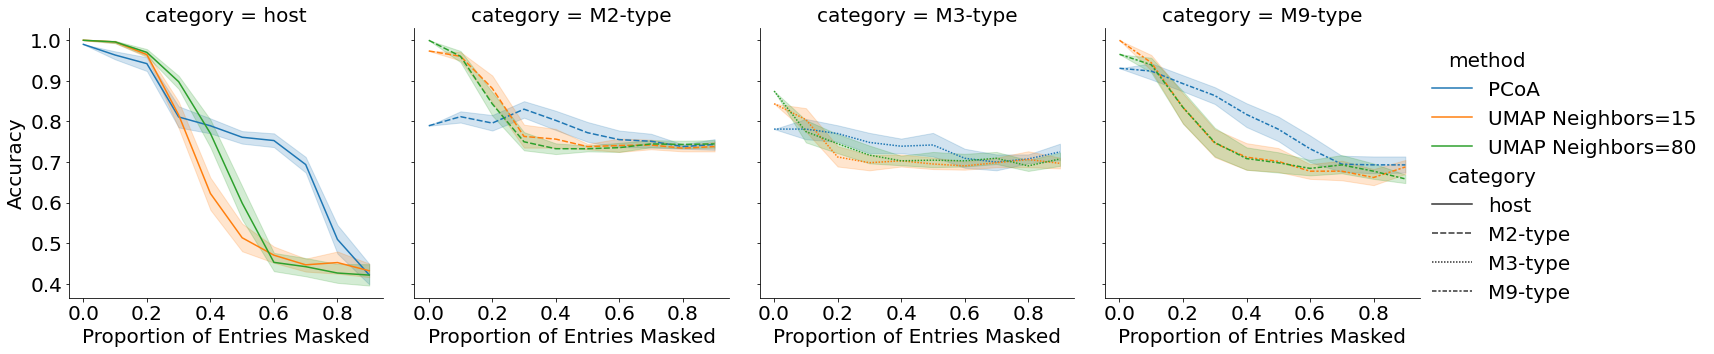

In [193]:
with sns.plotting_context(rc={'font.size': 20}):
    g = sns.relplot(
        x='Proportion of Entries Masked',
        y='Accuracy',
        hue='method',
        style='category',
        kind='line',
        col='category',
        data=mask_full_results.rename(
            {'mask_proportion': 'Proportion of Entries Masked',
             'accuracy': 'Accuracy',
             },
            axis=1),
    )
    # g.set_xlabel('Proportion of Entries Masked', fontsize=20)
    # g.set_ylabel('Accuracy', fontsize=20)

plt.savefig('results/sfig-keybaord-missing-values.svg',
            dpi=300)

<AxesSubplot:xlabel='mask_proportion', ylabel='accuracy'>

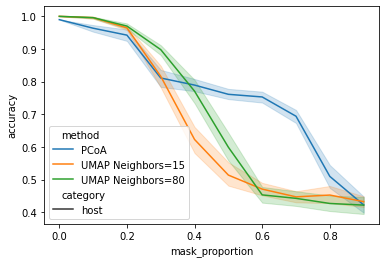

In [181]:
sns.lineplot(
    x='mask_proportion',
    y='accuracy',
    hue='method',
    style='category',
    data=mask_full_results.loc[mask_full_results['category'] == 'host'],
)

